In [2]:
import inspect


In [3]:
import random
import math
import numpy as np 

import math  # Para funções matemáticas como exp, log, tanh
from typing import List, Union

class Value:
    """
    Representa um valor escalar que participa de um grafo computacional
    para permitir a diferenciação automática (autograd).

    Attributes:
        data (float): The data for the Value node.
        _children (Tuple): The children of the current node.
    """
    
    def __init__(self, data: float, _children: tuple = (), _op: str = '', label: str = ''):
        """
        Inicializa um objeto Value.

        Args:
            data (float): O valor numérico escalar.
            _children (tuple, optional): Uma tupla de objetos Value que são os "filhos"
                                         (operandos) que geraram este Value. Default é ().
            _op (str, optional): A operação que gerou este Value (ex: '+', '*'). Default é ''.
            label (str, optional): Um rótulo opcional para este Value, útil para depuração. Default é ''.
        """
        self.data = data

        # The partial gradient of the last node with respect to this
        # node. This is also termed as the global gradient.
        # Gradient 0.0 means that there is no effect of the change
        # of the last node with respect to this node. On
        # initialization it is assumed that all the variables have no
        # effect on the entire architecture.

        self.grad = 0.0  # Gradiente da saída final da expressão em relação a este Value.]
        
        # The function that derives the gradient of the children nodes
        # of the current node. It is easier this way, because each node
        # is built from children nodes and an operation. Upon back-propagation
        # the current node can easily fill in the gradients of the children.
        # Note: The global gradient is the multiplication of the local gradient
        # and the flowing gradient from the parent.
        # Atributos internos para o backpropagation e construção do grafo:
        self._backward = lambda: None  # Função que propaga o gradiente para os filhos.]
                                      # Será sobrescrita por cada operação.
        
        # Define the children of this node.
        self._prev = set(_children)   # Conjunto dos nós filhos (operandos).]
        self._op = _op                # Operação que criou este nó.]
        self.label = label            # Rótulo para identificação.]

        # try:
        #     # FrameInfo(frame, filename, lineno, function, code_context, index)
        #     self.func = inspect.stack()[1].function
        # except IndexError:
        #     # Caso seja instanciado no escopo global ou de forma inesperada
        #     self.func = "<escopo global ou desconhecido>"

    def custom_addition(self, other: Union["Value", float]) -> "Value":
        """
        The addition operation for the Value class.
        Args:
            other (Union["Value", float]): The other value to add to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x + y
            >>> z.data
            5
        """
        # If the other value is not a Value, then we need to wrap it.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value node that will be the output of the addition.
        out = Value(data=self.data + other.data, _children=(self, other), label=f"add")
        def _backward():
            # Local gradient:
            # x = a + b
            # dx/da = 1
            # dx/db = 1
            # Global gradient with chain rule:
            # dy/da = dy/dx . dx/da = dy/dx . 1
            # dy/db = dy/dx . dx/db = dy/dx . 1
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    def custom_reverse_addition(self, other):
        """
        Reverse addition operation for the Value class.
        Args:
            other (float): The other value to add to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y + x
            >>> z.data
            5
        """
        # This is the same as adding. We can reuse the __add__ method.
        return self + other
    
    def custom_multiplication(self, other: Union["Value", float]) -> "Value":
        """
        The multiplication operation for the Value class.
        Args:
            other (float): The other value to multiply to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x * y
            >>> z.data
            6
        """
        # If the other value is not a Value, then we need to wrap it.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value node that will be the output of
        # the multiplication.
        out = Value(data=self.data * other.data, _children=(self, other), label=f"multi")
        def _backward():
            # Local gradient:
            # x = a * b
            # dx/da = b
            # dx/db = a
            # Global gradient with chain rule:
            # dy/da = dy/dx . dx/da = dy/dx . b
            # dy/db = dy/dx . dx/db = dy/dx . a
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        # Set the backward function on the output node.
        out._backward = _backward
        return out

    def custom_reverse_multiplication(self, other):
        """
        Reverse multiplication operation for the Value class.
        Args:
            other (float): The other value to multiply to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y * x
            >>> z.data
            6
        """
        # This is the same as multiplying. We can reuse the __mul__ method.
        return self * other
    
    def custom_power(self, other):
        """
        The power operation for the Value class.
        Args:
            other (float): The other value to raise this one to.
        Usage:
            >>> x = Value(2)
            >>> z = x ** 2.0
            >>> z.data
            4
        """
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        # Create a new Value node that will be the output of the power.
        out = Value(data=self.data ** other, _children=(self,), label=f"power")
        def _backward():
            # Local gradient:
            # x = a ** b
            # dx/da = b * a ** (b - 1)
            # Global gradient:
            # dy/da = dy/dx . dx/da = dy/dx . b * a ** (b - 1)
            self.grad += out.grad * (other * self.data ** (other - 1))
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    
    def custom_negation(self):
        """
        Negation operation for the Value class.
        Usage:
            >>> x = Value(2)
            >>> z = -x
            >>> z.data
            -2
        """
        # This is the same as multiplying by -1. We can reuse the
        # __mul__ method.
        return self * -1
    
    def custom_subtraction(self, other):
        """
        Subtraction operation for the Value class.
        Args:
            other (float): The other value to subtract to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x - y
            >>> z.data
            -1
        """
        # This is the same as adding the negative of the other value.
        # We can reuse the __add__ and the __neg__ methods.
        return self + (-other)
    def custom_reverse_subtraction(self, other):
        """
        Reverse subtraction operation for the Value class.
        Args:
            other (float): The other value to subtract to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y - x
            >>> z.data
            1
        """
        # This is the same as subtracting. We can reuse the __sub__ method.
        return other + (-self)
    
    def custom_division(self, other):
        """
        Division operation for the Value class.
        Args:
            other (float): The other value to divide to this one.
        Usage:
            >>> x = Value(10)
            >>> y = Value(5)
            >>> z = x / y
            >>> z.data
            2
        """
        # Use the __pow__ method to implement division.
        return self * other ** -1
    def custom_reverse_division(self, other):
        """
        Reverse division operation for the Value class.
        Args:
            other (float): The other value to divide to this one.
        Usage:
            >>> x = Value(10)
            >>> y = Value(5)
            >>> z = y / x
            >>> z.data
            0.5
        """
        # Use the __pow__ method to implement division.
        return other * self ** -1
    

    # Value.__truediv__ = custom_division
    # Value.__rtruediv__ = custom_reverse_division
    # Value.__sub__ = custom_subtraction
    # Value.__rsub__ = custom_reverse_subtraction
    # Value.__neg__ = custom_negation
    # Value.__pow__ = custom_power
    # Value.__mul__ = custom_multiplication
    # Value.__rmul__ = custom_reverse_multiplication
    # Value.__add__ = custom_addition
    # Value.__radd__ = custom_reverse_addition

    def __repr__(self) -> str:
        """
        Representação em string do objeto Value, mostrando data, rótulo e gradiente.
        """
        return f"Value(data={self.data:.4f}, label='{self.label}', grad={self.grad:.4f})"

    def _ensure_value(self, other) -> 'Value':
        """
        Garante que o 'other' operando seja também um objeto Value.
        Se for um número (int ou float), ele é convertido para Value.
        """
        return other if isinstance(other, Value) else Value(other)

    # --- Operações Aritméticas e Métodos Especiais ---

    def __add__(self, other) -> 'Value':
        """
        Implementa a adição: self + other.
        """
        other = self._ensure_value(other) # Garante que 'other' seja um Value]
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Derivada da soma: d(out)/d(self) = 1, d(out)/d(other) = 1
            # Aplicando a regra da cadeia: dL/d(self) = dL/d(out) * d(out)/d(self)
            self.grad += 1.0 * out.grad  #]
            other.grad += 1.0 * out.grad #]
        out._backward = _backward
        
        return out

    def __mul__(self, other) -> 'Value':
        """
        Implementa a multiplicação: self * other.
        """
        other = self._ensure_value(other) # Garante que 'other' seja um Value]
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Derivada do produto: d(out)/d(self) = other.data, d(out)/d(other) = self.data
            self.grad += other.data * out.grad  #]
            other.grad += self.data * out.grad #]
        out._backward = _backward
          
        return out

    def __pow__(self, other: float) -> 'Value':
        """
        Implementa a potenciação: self ** other (onde 'other' é um escalar int ou float).
        """
        assert isinstance(other, (int, float)), "Apenas potências escalares (int/float) são suportadas por enquanto."
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # Derivada de x^n = n * x^(n-1)
            self.grad += (other * (self.data ** (other - 1))) * out.grad #]
        out._backward = _backward

        return out
        
    def __neg__(self) -> 'Value': # -self
        """
        Implementa a negação: -self. É o mesmo que self * -1.
        """
        return self * -1 #]

    def __sub__(self, other) -> 'Value': # self - other
        """
        Implementa a subtração: self - other. É o mesmo que self + (-other).
        """
        return self + (-other) #]

    def __truediv__(self, other) -> 'Value': # self / other
        """
        Implementa a divisão: self / other. É o mesmo que self * (other ** -1).
        """
        return self * (self._ensure_value(other) ** -1) #]

    # Métodos refletidos para operações onde Value não é o primeiro operando (ex: 2 + a)
    def __radd__(self, other) -> 'Value': # other + self
        return self + other #]

    def __rsub__(self, other) -> 'Value': # other - self
        return self._ensure_value(other) + (-self)

    def __rmul__(self, other) -> 'Value': # other * self
        return self * other #]

    def __rtruediv__(self, other) -> 'Value': # other / self
        return self._ensure_value(other) * (self ** -1)

    # --- Funções de Ativação e Outras Funções Matemáticas ---

    def relu(self):
        """
        The ReLU activation function.
        Usage:
            >>> x = Value(-2)
            >>> y = x.relu()
            >>> y.data
            0
        """
        out = Value(data=0 if self.data < 0 else self.data, _children=(self,), label=f"relu")
        def _backward():
            # Local gradient:
            # x = relu(a)
            # dx/da = 0 if a < 0 else 1
            # Global gradient:
            # dy/da = dy/dx . dx/da = dy/dx . (0 if a < 0 else 1)
            self.grad += out.grad * (out.data > 0)
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    def tanh(self) -> 'Value':
        """
        Implementa a função de ativação tangente hiperbólica.
        tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) #]
        out = Value(t, (self, ), 'tanh', label=f"tanh")
        
        def _backward():
            # Derivada de tanh(x) = 1 - tanh(x)^2 = 1 - t^2
            self.grad += (1 - t**2) * out.grad #]
        out._backward = _backward
        
        return out

    def exp(self) -> 'Value':
        """
        Implementa a função exponencial: e ** self.data
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp', label=f"exp") #]
        
        def _backward():
            # Derivada de e^x = e^x
            self.grad += out.data * out.grad # out.data é e^x]
        out._backward = _backward
        return out

    def log(self, base: float = math.e) -> 'Value':
        """
        Implementa a função logarítmica (log natural por padrão).
        """
        x = self.data
        if x <= 0:
            raise ValueError("Logaritmo indefinido ou complexo para data <= 0.")
        
        # Logaritmo na base desejada
        log_val = math.log(x, base)
        out = Value(log_val, (self,), f'log_base{base:.2f}', label=f"log")
        
        def _backward():
            # Derivada de log_b(x) = 1 / (x * ln(b))
            # Para log natural (ln(x), base=e), a derivada é 1/x.
            self.grad += (1 / (x * math.log(base))) * out.grad
        out._backward = _backward
        return out
    
    # def tanh(self):
    #     x = self.data
    #     t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    #     out = Value(t, (self, ), 'tanh', label=f"")
        
    #     def _backward():
    #         self.grad += (1 - t**2) * out.grad
    #     out._backward = _backward
        
    #     return out
    
    # def exp(self):
    #     x = self.data
    #     out = Value(math.exp(x), (self, ), 'exp')
        
    #     def _backward():
    #         self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    #     out._backward = _backward
        
    #     return out

    # --- Backpropagation ---
    def backward(self):
        """
        Realiza o backpropagation a partir deste Value (geralmente o nó de perda).
        Calcula os gradientes para todos os Values no grafo que levaram a este.

        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x * y
            >>> z.backward()
            >>> x.grad
            3
            >>> y.grad
            2
        """
        # Build an empty list which will hold the
        # topologically sorted graph
        topo = []
        # Build a set of all the visited nodes
        visited = set()
        # A closure to help build the topologically sorted graph
        def build_topo(node: "Value"):
            if node not in visited:
                # If node is not visited add the node to the
                # visited set.
                visited.add(node)
                # Iterate over the children of the node that
                # is being visited
                for child in node._prev:
                    # Apply recursion to build the topologically sorted
                    # graph of the children
                    build_topo(child)
                
                # Only append node to the topologically sorted list
                # if all its children are visited.
                topo.append(node)
        # Call the `build_topo` method on self
        build_topo(self)
        # Go one node at a time and apply the chain rule
        # to get its gradient
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [4]:
class Module(object):
    """
    the parent class for all neutal network
    """

    def zero_grad(self):
        """
        This is used to zero out all the gradients of the parameters.
        """
        for p in self.parameters():
            p.grad = 0


    def parameters(self):
        """
        This function is built to be overwritten. This would eventually get us the parameters of the neurons, layers, and the mlp.
        """
        return []

In [5]:
import random
from typing import List

class Neuron(Module):
    """
    A single neuron.
    Parameters:
        number_inputs (int): number of inputs
        is_nonlinear (bool): whether to apply ReLU nonlinearity
        name (int): the index of neuron
    """
    def __init__(self, number_inputs: int, name, is_nonlinear: bool = True):
        # Create weights for the neuron. The weights are initialized from a random uniform distribution.
        self.weights = [Value(data=random.uniform(-1, 1), label=f"neuron weight: {name}") for _ in range(number_inputs)]
        # Create bias for the neuron.
        self.bias = Value(data=0.0, label=f"neuron bias: {name}")
        self.is_nonlinear = is_nonlinear
        self.name = name

    def __call__(self, x: List["Value"]) -> "Value":
        # Calcula a soma ponderada + bias
            # w.x + b
        # Compute the dot product of the input and the weights. 
        # Add the bias to the dot product.

        act = sum(
            ((wi * xi) for wi, xi in zip(self.weights, x)),
            self.bias
        )
        # If activation is mentioned, apply ReLU to it.
        return act.relu() if self.is_nonlinear else act # Aplica tanh ou retorna linear

    def parameters(self):
        # Get the parameters of the neuron. The parameters of a neuron
        # is its weights and bias.
        return self.weights + [self.bias]

    def __repr__(self):
        # Print a better representation of the neuron.
        return f"Neuron {self.name}(Number={len(self.weights)}, Non-Linearity={'ReLU' if self.is_nonlinear else 'None'})"
    
x = [2.0, 3.0]
neuron = Neuron(number_inputs=2, name=1)
print(neuron)
out = neuron(x)
print(f"Output => {out}")

Neuron 1(Number=2, Non-Linearity=ReLU)
Output => Value(data=0.1348, label='relu', grad=0.0000)


In [6]:
class Layer(Module):
    """
    A layer of neurons.
    Parameters:
        number_inputs (int): number of inputs
        number_outputs (int): number of outputs
        name (int): index of the layer
    """
    def __init__(self, number_inputs: int, number_outputs: int, name: int, **kwargs):
        # A layer is a list of neurons.
        self.neurons = [
            Neuron(number_inputs=number_inputs, 
                   name=idx, **kwargs) for idx in range(number_outputs)
        ]
        self.name = name
        self.number_outputs = number_outputs

    def __call__(self, x: List["Value"]) -> Union[List["Value"], "Value"]:
        # Iterate over all the neurons and compute the output of each.
        outs = [n(x) for n in self.neurons]

        return outs if self.number_outputs != 1 else outs[0] # Retorna único valor ou lista

    def parameters(self):
        # The parameters of a layer is the parameters of all the neurons.
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self):
        # Print a better representation of the layer.
        layer_str = "\n".join(f'    - {str(n)}, input_size = {len(n.weights)}' for n in self.neurons)
        return f"Layer {self.name} \n{layer_str}\n"
    
    
x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=3, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")
print()

x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=1, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")

Layer 1 
    - Neuron 0(Number=2, Non-Linearity=ReLU), input_size = 2
    - Neuron 1(Number=2, Non-Linearity=ReLU), input_size = 2
    - Neuron 2(Number=2, Non-Linearity=ReLU), input_size = 2

Output => [Value(data=2.4412, label='relu', grad=0.0000), Value(data=0.0000, label='relu', grad=0.0000), Value(data=0.8602, label='relu', grad=0.0000)]

Layer 1 
    - Neuron 0(Number=2, Non-Linearity=ReLU), input_size = 2

Output => Value(data=0.0000, label='relu', grad=0.0000)


In [7]:
class MLP(Module):
    """
    The Multi-Layer Perceptron (MLP) class.
    Parameters:
        number_inputs (int): number of inputs.
        list_number_outputs (List[int]): number of outputs in each layer.
    """
    def __init__(self, number_inputs: int, list_number_outputs: List[int]):
        # Get the number of inputs and all the number of outputs in a single list.

        # Tamanhos das camadas: [n_inputs, n_hidden1, n_hidden2, ..., n_output]
        total_size = [number_inputs] + list_number_outputs

        # Build layers by connecting each layer to the previous one.
        self.layers = [
            # Do not use non linearity in the last layer.
            Layer(
                number_inputs=total_size[i],
                number_outputs=total_size[i + 1],
                name=i,
                is_nonlinear=i != len(list_number_outputs) - 1
            )
            for i in range(len(list_number_outputs))
        ]

        # A última camada geralmente é linear (is_nonlinear=False) antes da loss,
        # ou a não-linearidade é parte da função de loss (ex: Softmax com CrossEntropy)
        # No micrograd, é comum aplicar tanh até na última camada se for uma saída genérica.

    def __call__(self, x: List["Value"]) -> List["Value"]:
        # Iterate over the layers and compute the output of
        # each sequentially.
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # Get the parameters of the MLP
        return [layer for layer in self.layers for layer in layer.parameters()]
    
    def __repr__(self):
        # Print a better representation of the MLP.
        mlp_str = "\n".join(f'  - {str(layer)}' for layer in self.layers)
        return f"MLP of \n{mlp_str}"

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

x = [2.0, 3.0]
mlp = MLP(number_inputs=2, list_number_outputs=[3, 3, 1])
print(mlp)
out = mlp(x)
print(f"Output => {out}")

MLP of 
  - Layer 0 
    - Neuron 0(Number=2, Non-Linearity=ReLU), input_size = 2
    - Neuron 1(Number=2, Non-Linearity=ReLU), input_size = 2
    - Neuron 2(Number=2, Non-Linearity=ReLU), input_size = 2

  - Layer 1 
    - Neuron 0(Number=3, Non-Linearity=ReLU), input_size = 3
    - Neuron 1(Number=3, Non-Linearity=ReLU), input_size = 3
    - Neuron 2(Number=3, Non-Linearity=ReLU), input_size = 3

  - Layer 2 
    - Neuron 0(Number=3, Non-Linearity=None), input_size = 3

Output => Value(data=0.0000, label='', grad=0.0000)


### Exemplo de Esqueleto do Loop de Treinamento:

In [14]:
# Supondo que você tenha a função draw_dot como nos notebooks micrograd
# Se precisar, aqui está uma versão simplificada (requer 'graphviz' instalado: pip install graphviz)
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    from graphviz import Digraph
    """
    format: png | pdf | svg
    rankdir: TB (top-bottom graph) | LR (left-right graph)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': rankdir})

    for n in nodes:
        label = f"data {n.data:.4f} | grad {n.grad:.4f} | label {n.label}"
        dot.node(name=str(id(n)), label = label, shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [31]:
def forward(mlp: "MLP", x_data:List[List[float]]) -> List["Value"]:
    """
    The forward function takes the mlp and the inputs. The inputs are forwarded through the mlp, and we obtain the predictions from the mlp.
    """
    # Get the predictions upon forwarding the input data through the mlp
    y_pred_list = [mlp(x) for x in x_data]
    return y_pred_list

def update_mlp(mlp: "MLP", learning_rate:float):
    """
    In this function, we update the parameters (weights and biases) of our mlp with the gradient information.

    **Como funciona o ajuste?**
    - Para cada parâmetro p no mlp:
        - Se p.grad é positivo (aumentar p aumenta a perda), então p.data é diminuído (pois subtraímos `learning_rate` * p.grad, que é um valor positivo).
        - Se p.grad é negativo (aumentar p diminui a perda), então p.data é aumentado (pois subtraímos `learning_rate` * p.grad, que é um valor negativo, resultando em uma adição).
    
    - O `learning_rate` (taxa de aprendizado) controla o "tamanho do passo" que damos ao ajustar os parâmetros. 
        - Uma taxa muito alta pode fazer o modelo "pular" o ponto ótimo; 
        - uma taxa muito baixa pode tornar o aprendizado excessivamente lento.
    - O resultado líquido é que todos os pesos e biases do mlp são sutilmente alterados em uma direção que, espera-se, reduza a total_loss na próxima vez que o forward pass for executado com os mesmos dados.
    """
    # Update (Gradiente Descendente)
    for layer in mlp.parameters():
        layer.data -= learning_rate * layer.grad


In [10]:
# Função genérica para converter qualquer vetor/lista y em lista de objetos Value (com rótulo opcional)
def to_value_vector(y, label_prefix="y"):
    """
    Converte um vetor/lista y em uma lista de objetos Value, com rótulo customizado.
    """
    return [Value(v, label=f"{label_prefix} {i}") for i, v in enumerate(y)]

def to_value_matrix(X, label_prefix="input"):
    """
    Converte uma matriz X (list of lists ou np.ndarray) em uma lista de listas de objetos Value,
    com rótulo customizado para cada entrada.
    """
    return [
        [Value(v, label=f"{label_prefix} {i}_{j}") for j, v in enumerate(row)]
        for i, row in enumerate(X)
    ]

In [103]:
# Exemplo de dados "moon" (adaptado de scikit-learn, mas simplificado)
X_data = [
  [1.0, 2.0], [1.5, 1.8], [2.0, 1.0], [2.5, 1.5], [1.2, 0.5], [2.8, 0.8], # Classe A (aprox)
  [3.0, 3.0], [3.5, 2.5], [4.0, 3.5], [4.5, 2.8], [3.2, 4.0], [4.8, 3.2]  # Classe B (aprox)
]

y_data = [1.0]*6 + [-1.0]*6 # Rótulos para SVM loss

X_data_values = to_value_matrix(X_data)
y_data_values = to_value_vector(y_data)

# Converta dados para objetos Value (se seu MLP espera Value como entrada inicial)
# Se o seu MLP lida com floats na primeira camada, isso não é necessário aqui.
# Neste exemplo, vamos assumir que a primeira camada do MLP pode pegar floats.
# No micrograd original, as entradas X são convertidas para Values antes de chamar o MLP.
# X = [[Value(v) for v in x_row] for x_row in X_data]
# ys = [Value(v) for v in y_data]

# --- Configuração do MLP ---
mlp = MLP(number_inputs=2, list_number_outputs=[4, 4, 1]) # 2 entradas, 2 camadas ocultas com 4 neurônios, 1 saída
learning_rate = 0.05
epochs = 100

print(f"Número total de parâmetros: {len(mlp.parameters())}")

def compute_loss(y_true:List[int], y_pred:List["Value"]) -> "Value":
    """
    Se a predição já satisfaz essa condição de margem, a perda para aquela amostra é zero. Caso contrário, a perda é positiva.
    """
    losses = [(Value(1.0, label=f"compute_loss") + -y_true[i]*y_pred[i]).relu() for i in range(len(y_true))]
    data_loss = sum(losses) * (1.0 / len(losses)) # Média da perda

    return data_loss

# --- Loop de Treinamento ---
train_feedback = []
for epoch in range(epochs):
    
    """

    O MLP está aprendendo da seguinte forma:
    1, `Tenta` fazer previsões com seus parâmetros atuais.
    2. `Mede` o quão erradas foram suas tentativas (calcula a perda).
    3. `Descobre` como cada um de seus parâmetros internos contribuiu para esse erro específico (calcula os gradientes via backpropagation).
    4. `Ajusta` sutilmente cada parâmetro na direção que deve reduzir o erro no futuro (atualiza os parâmetros usando o gradiente descendente).
    5. `Repete` esse processo muitas vezes (épocas), melhorando gradualmente.    
    """
    # Forward pass & Loss calculation

    total_loss_epoch = 0.0
    y_predictions_epoch = [] # Para guardar as predições da rede (objetos Value)

    y_predictions_epoch = forward(mlp=mlp, x_data=X_data_values)

    # Calcular a perda SVM "max-margin" (exemplo)
    # loss = sum((1 + -yi*scorei).relu() for yi, scorei in zip(ys_values, y_predictions_epoch)) / len(ys_values)
    # Ou uma perda de erro quadrático simples se for regressão ou se os rótulos forem 0/1 e usar sigmoide.
    # Para SVM-like loss:
    # losses = [(Value(1.0) + -y_data[i]*y_predictions_epoch[i]).relu() for i in range(len(y_data))]
    # data_loss = sum(losses) * (1.0 / len(losses)) # Média da perda

    data_loss = compute_loss(y_true=y_data, 
                             y_pred=y_predictions_epoch)

    # Regularização (opcional, mas bom para evitar overfitting)
    # (Regularização L2): Este termo penaliza pesos (p) grandes no mlp. 
    # Adicionar $α∑p^2$ à perda total ajuda a prevenir o overfitting, encorajando o modelo a encontrar soluções mais "simples" (com pesos menores).
    alpha = 1e-4 # Força da regularização
    reg_loss = alpha * sum((p*p for p in mlp.parameters()))
    total_loss = data_loss + reg_loss

    # Backward pass
    mlp.zero_grad()   # Zerar gradientes de todas as execuções anteriores
    total_loss.backward() # Calcular gradientes a partir da perda total

    # Update (Gradiente Descendente)
    update_mlp(mlp=mlp, learning_rate=learning_rate)
    # update_mlp_b(mlp, learning_rate)

    total_loss_epoch = total_loss.data

    accuracy = sum(1 for i in range(len(y_data)) if (y_predictions_epoch[i].data > 0) == (y_data[i] > 0)) / len(y_data)
    if epoch % 5 == 0 or epoch == epochs - 1:
        # Avaliar acurácia (para classificação)
        # Aqui, apenas verificamos se o sinal do score corresponde ao rótulo y_data (-1 ou 1)
        print(f"Epoch {epoch}: Loss = {total_loss_epoch:.4f}, Accuracy = {accuracy*100:.2f}%")

    train_feedback.append({"epoch":epoch, "loss":round(total_loss_epoch, 4), "accuracy":round(accuracy, 2)})
# Após o treinamento, você pode usar mlp(new_x_value) para fazer previsões.
# E visualizar o grafo de 'total_loss' da última época com draw_dot.
# from micrograd.engine import Value # Supondo que Value esteja aqui
# from micrograd.nn import Neuron, Layer, MLP # Supondo que suas classes estejam aqui
# ... seu código de Value, Neuron, Layer, MLP ...
# from graphviz import Digraph # (Se você copiou a função draw_dot)



Número total de parâmetros: 37
Epoch 0: Loss = 1.1516, Accuracy = 50.00%
Epoch 5: Loss = 0.9847, Accuracy = 58.33%
Epoch 10: Loss = 0.9785, Accuracy = 58.33%
Epoch 15: Loss = 0.9725, Accuracy = 58.33%
Epoch 20: Loss = 0.9655, Accuracy = 58.33%
Epoch 25: Loss = 0.9579, Accuracy = 58.33%
Epoch 30: Loss = 0.9504, Accuracy = 58.33%
Epoch 35: Loss = 0.9460, Accuracy = 58.33%
Epoch 40: Loss = 0.9415, Accuracy = 58.33%
Epoch 45: Loss = 0.9344, Accuracy = 58.33%
Epoch 50: Loss = 0.9236, Accuracy = 66.67%
Epoch 55: Loss = 0.9106, Accuracy = 58.33%
Epoch 60: Loss = 0.8992, Accuracy = 75.00%
Epoch 65: Loss = 0.8835, Accuracy = 66.67%
Epoch 70: Loss = 0.8566, Accuracy = 75.00%
Epoch 75: Loss = 0.8246, Accuracy = 91.67%
Epoch 80: Loss = 0.7647, Accuracy = 91.67%
Epoch 85: Loss = 0.7869, Accuracy = 100.00%
Epoch 90: Loss = 0.6557, Accuracy = 100.00%
Epoch 95: Loss = 0.5914, Accuracy = 58.33%
Epoch 99: Loss = 0.6000, Accuracy = 100.00%


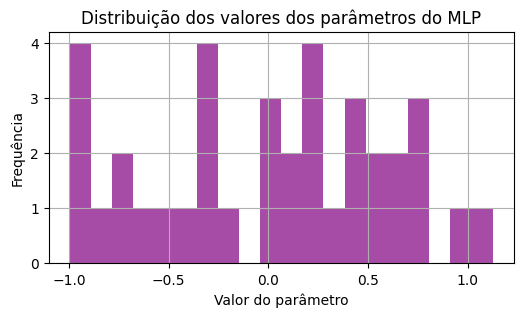

In [104]:
# 1. Distribuição dos valores dos parâmetros (weights e bias) do MLP ao final do treinamento
import matplotlib.pyplot as plt

params = mlp.parameters()
weights = [p.data for p in params]
plt.figure(figsize=(6,3))
plt.hist(weights, bins=20, color='purple', alpha=0.7)
plt.title("Distribuição dos valores dos parâmetros do MLP")
plt.xlabel("Valor do parâmetro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [105]:
from collections import Counter

Counter([round(w, 1) for w in weights])

Counter({-0.3: 4,
         0.7: 3,
         0.2: 3,
         0.6: 3,
         0.4: 3,
         0.0: 3,
         -1.0: 2,
         0.3: 2,
         -0.9: 2,
         0.1: 2,
         -0.8: 2,
         -0.5: 1,
         -0.4: 1,
         0.8: 1,
         -0.6: 1,
         1.0: 1,
         -0.7: 1,
         1.1: 1,
         -0.2: 1})

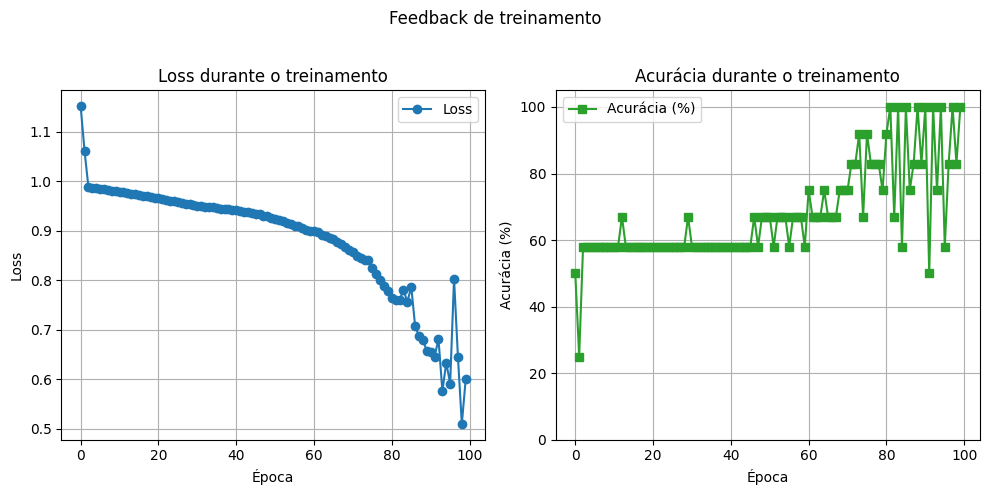

In [106]:
import matplotlib.pyplot as plt


list_epoch = [dict_feedback.get("epoch", 0) for dict_feedback in train_feedback]
list_loss = [dict_feedback.get("loss", 0) for dict_feedback in train_feedback]
list_accuracy = [dict_feedback.get("accuracy", 0) for dict_feedback in train_feedback]

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(list_epoch, list_loss, marker='o', color='tab:blue', label='Loss')
plt.title("Loss durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(list_epoch, [a * 100 for a in list_accuracy], marker='s', color='tab:green', label='Acurácia (%)')
plt.title("Acurácia durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.ylim(0, 105)
plt.grid(True)
plt.legend()

plt.suptitle("Feedback de treinamento")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [19]:
data_loss

Value(data=0.8283, label='', grad=0.0000)

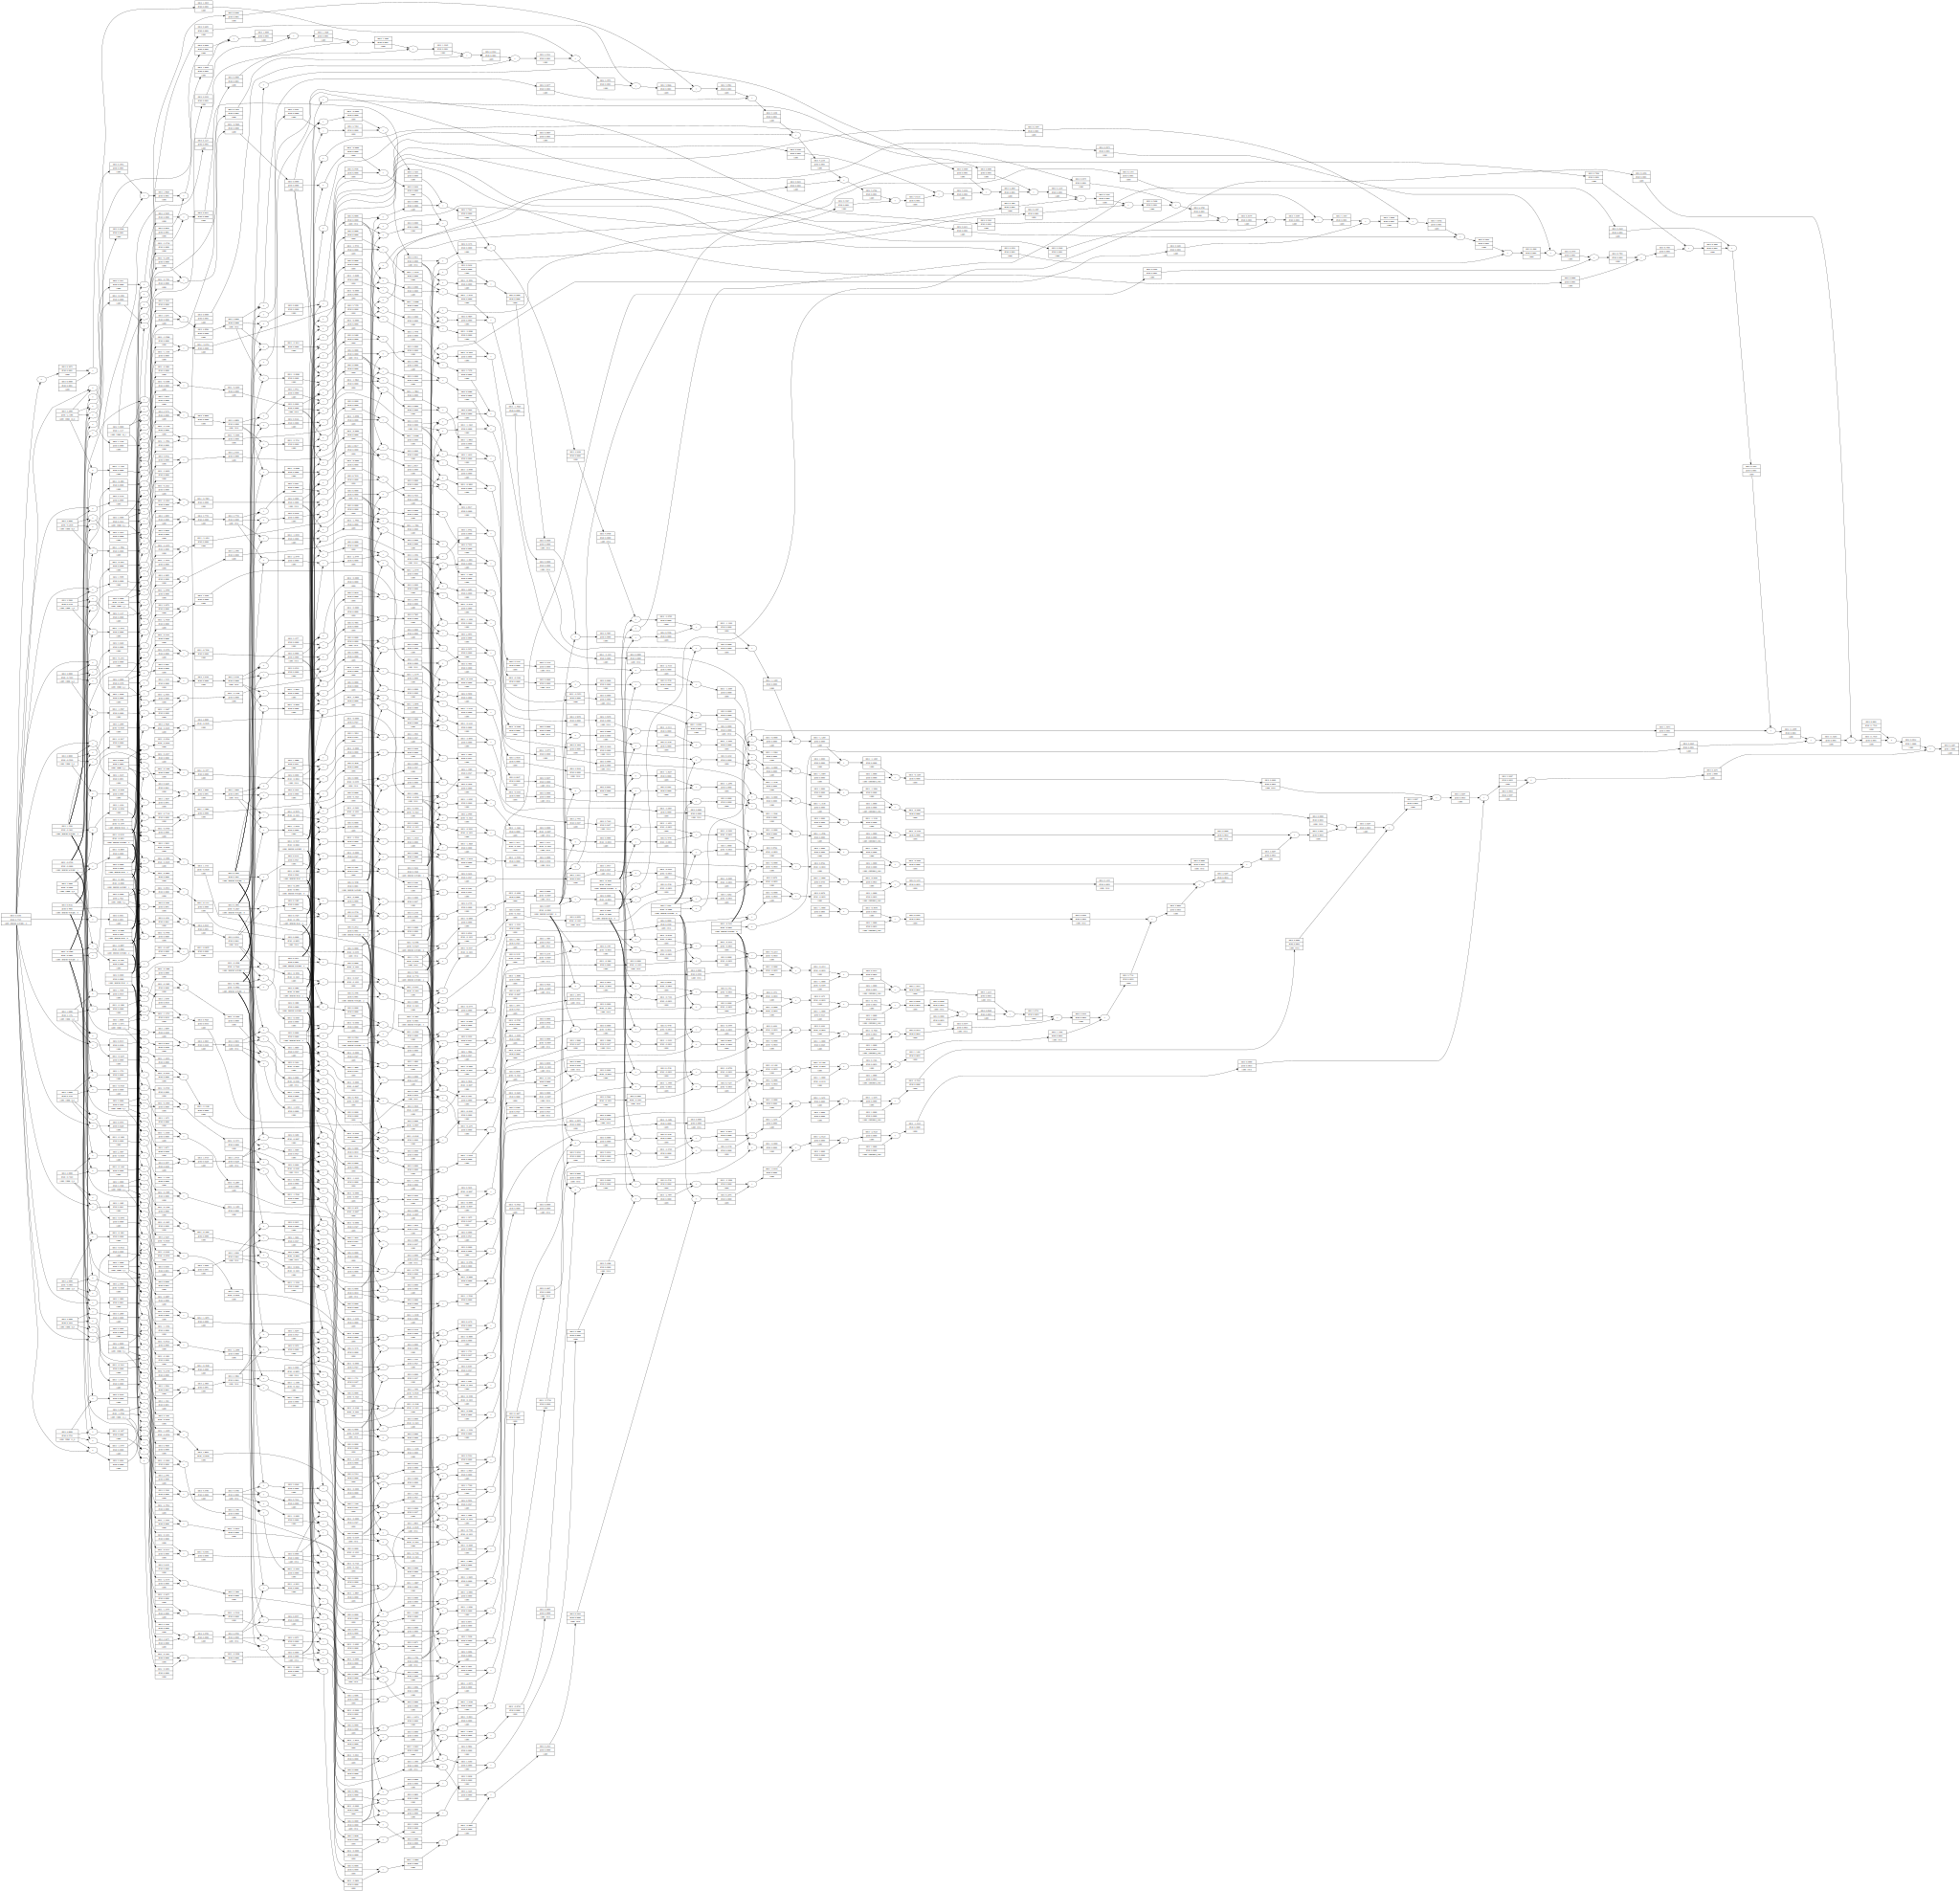

In [15]:
draw_dot(total_loss)

In [ ]:
end

NameError: name 'end' is not defined

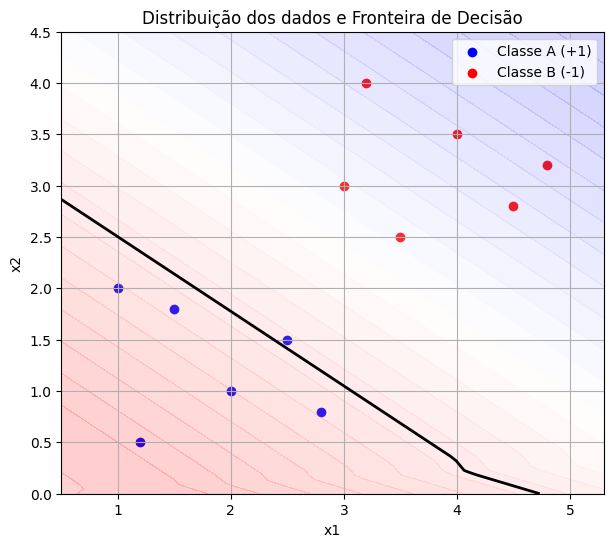

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Melhoria: Função para plotar dados e decisão do MLP

def plot_data_and_decision(X_data, y_data, mlp, resolution=100):

    X_data_A = [X_data[i] for i in range(len(y_data)) if y_data[i] == 1.0]
    X_data_B = [X_data[i] for i in range(len(y_data)) if y_data[i] == -1.0]

    plt.figure(figsize=(7, 6))
    plt.scatter([x[0] for x in X_data_A], [x[1] for x in X_data_A], color='blue', label='Classe A (+1)')
    plt.scatter([x[0] for x in X_data_B], [x[1] for x in X_data_B], color='red', label='Classe B (-1)')

    # Plotar a fronteira de decisão do MLP
    x_min, x_max = min(x[0] for x in X_data) - 0.5, max(x[0] for x in X_data) + 0.5
    y_min, y_max = min(x[1] for x in X_data) - 0.5, max(x[1] for x in X_data) + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = np.array([mlp(list(pt)).data for pt in grid])
    zz = zz.reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=np.linspace(zz.min(), zz.max(), 25), alpha=0.2, cmap='bwr')
    plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2)  # Fronteira de decisão

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Distribuição dos dados e Fronteira de Decisão')
    plt.legend()
    plt.grid(True)
    plt.show()


# Exemplo de dados "moon" (adaptado de scikit-learn, mas simplificado)
X_data = np.array([
  [1.0, 2.0], [1.5, 1.8], [2.0, 1.0], [2.5, 1.5], [1.2, 0.5], [2.8, 0.8], # Classe A (aprox)
  [3.0, 3.0], [3.5, 2.5], [4.0, 3.5], [4.5, 2.8], [3.2, 4.0], [4.8, 3.2]  # Classe B (aprox)
])
y_data = [1.0]*6 + [-1.0]*6 # Rótulos para SVM loss

plot_data_and_decision(X_data, y_data, mlp)

In [ ]:

# Exemplo para visualizar o grafo da última perda calculada:
# (Certifique-se que total_loss é um objeto Value)
g = draw_dot(total_loss)
g.render('mlp_loss_graph', view=True) # Salva como mlp_loss_graph.svg (ou .pdf) e tenta abrir

'mlp_loss_graph.svg'

---

Dataset iris

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Carregar o dataset
iris = load_iris()
X, y = iris.data, iris.target

# Pré-processamento: Padronizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Se seu MLP espera y como one-hot encoding para multiclasse:
# (Assumindo que n_classes = 3 para o Iris dataset)
# y_train_one_hot = np.eye(len(np.unique(y_train)))[y_train]
# y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
# print(f"Formato de y_train_one_hot: {y_train_one_hot.shape}") # Se usar one-hot

#X_train
#y_train

Formato de X_train: (105, 4)
Formato de y_train: (105,)


In [ ]:
X_train[0]

array([-0.90068117, -1.28296331, -0.4308277 , -0.13075464])

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

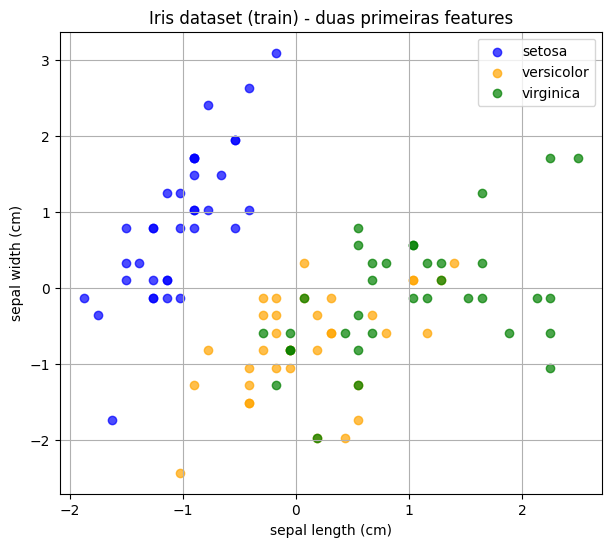

In [ ]:
import matplotlib.pyplot as plt

# Vamos plotar as duas primeiras features do conjunto de treino do iris
plt.figure(figsize=(7, 6))
for label, color, name in zip([0, 1, 2], ['blue', 'orange', 'green'], iris.target_names):
    idx = y_train == label
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=name, color=color, alpha=0.7)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Iris dataset (train) - duas primeiras features')
plt.legend()
plt.grid(True)
plt.show()